<a href="https://colab.research.google.com/github/mathewsrc/Streamlined-ETL-Process-Unleashing-Polars-Dataprep-and-Airflow/blob/master/notebooks/gov_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streamlined ETL Process: Unleashing Polars and Dataprep

**Project Summary:**

This ETL (Extract, Transform, Load) project employs several Python libraries, including Polars, Dataprep, Requests, BeautifulSoup, and Loguru, to streamline the extraction, transformation, and loading of CSV datasets from the U.S. government's data repository at https://catalog.data.gov.



**Project Objectives:**

Extraction: I utilize the requests library and BeautifulSoup to scrape datasets from https://catalog.data.gov, a repository of various data formats, including CSV, XLS, and HTML.

Transformation: Data manipulation and cleaning are accomplished using Polars, a high-performance data manipulation library written in Rust.

Data Profiling: Dataprep is employed to create dynamic data reports and facilitate data profiling, quality assessment, and visualization, providing insights into data quality and characteristics.

Loading: Transformed data is saved in CSV files using Polars.

Logging: Loguru is chosen for logging, ensuring transparency and facilitating debugging throughout the ETL process.

Through the automation of these ETL tasks, I establish a robust data pipeline that transforms raw data into valuable assets, supporting informed decision-making and data-driven insights.

**Directory structure**

- **data/raw/**: Contains raw data files.
- **data/interim/**: Contains intermediary processed data.
- **data/processed/**: Contains processed data.
- **data/reports/**: Contains reports for each dataset.

### Install libraries

In [197]:
!pip install --upgrade pip
!pip install -q loguru==0.7.2
!pip install -q polars==0.19.7
!pip install -q furl==2.1.3
!pip install -q tqdm==4.66.1
!pip install -q dataprep==0.4.5
!pip install -q requests==2.31.0
!pip install -q pandas==1.5.3 # pandas 2.1.1 does not work with dataprep current version
!pip install -q beautifulsoup4==4.11.2
!pip install -q duckdb==0.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 45.4 MB/s eta 0:00:00


### Import libraries

In [198]:
import requests
import furl
import polars as pl
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import os
from loguru import logger
import sys
import re
from datetime import datetime
from tqdm import tqdm
import dataprep
from dataprep.eda import create_report
import duckdb

In [3]:
import warnings

# Filter out warnings throwed by dataprep
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# Print package versions
print(f"requests version: {requests.__version__}") #2.31.0
print(f"furl version: {furl.__version__}") #2.1.3
print(f"polars version: {pl.__version__}") #0.19.7
print(f"BeautifulSoup version: {bs4.__version__}") #4.11.2
print(f"pandas version: {pd.__version__}") #1.5.3
print(f"Python version: {sys.version}")

requests version: 2.31.0
furl version: 2.1.3
polars version: 0.19.7
BeautifulSoup version: 4.11.2
pandas version: 1.5.3
Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


Create directories to save data

In [5]:
# Define the directories to save data

raw_dir = "./data/raw"
interim_dir = "./data/interim"
processed_dir = "./data/processed"
reports_dir = "./data/reports"

# Create directories
for dir in [raw_dir, interim_dir, processed_dir, reports_dir]:
    os.makedirs(dir, exist_ok=True)

Define files time period to improve organization

In [6]:
# Get the current date and time
current_datetime = datetime.now()

# Format the current date and time to obtain the time period as "YYYY-MM"
time_period = current_datetime.strftime("%Y_%m")
logger.info(f"Time period: {time_period}")

2023-10-21 20:34:42.813 | INFO     | __main__:<cell line: 6>:6 - Time period: 2023_10


## Extract

In [7]:
import re

@logger.catch
def format_url(url):
    """
    Format URL

    Args:
        url (str): The original URL to be formatted.

    Returns:
        str: The formatted URL.

    Example:
        >>> format_url("https://www.ers.usda.gov/page?q=example")
        'https://www.ers.usda.gov/page'
    """


    # Define a regular expression pattern to remove query parameters from the URL
    pattern = r'\?.+'

    # Use regular expression substitution to remove the pattern from the URL
    url = re.sub(pattern, '', url)

     # Define a prefix for the URL
    prefix = "https://www.ers.usda.gov"

    # Add prefix if URL does not start with https:// or http://
    if not url.startswith("https://") and not url.startswith("http://"):
        url = furl.furl(prefix).add(path=url).url

    return url

Assert that `format_url()` is working as expected


In [8]:
# Testing the function with assertions
assert format_url("https://www.ers.usda.gov/page?q=example") == 'https://www.ers.usda.gov/page'
assert format_url("https://www.ers.usda.gov/") == 'https://www.ers.usda.gov/'
assert format_url("/webdocs/DataFiles/106595/Dates2020.csv?v=5007.3") == "https://www.ers.usda.gov/webdocs/DataFiles/106595/Dates2020.csv"
assert format_url("/webdocs/DataFiles/51035/FruitPrices2020.csv?v=5007") == "https://www.ers.usda.gov/webdocs/DataFiles/51035/FruitPrices2020.csv"
assert format_url("https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD") == "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv"

In [9]:
import re

@logger.catch
def modify_file_name(name):
    """
    Modify a file name by performing the following transformations:

    Args:
        name (str): The original file name to be modified.

    Returns:
        str: The modified file name.

    Example:
        >>> modify_file_name("My File 123.txt")
        'my_file_123.txt'

        >>> modify_file_name("!@#File Name$%^")
        'file_name'
    """

    # Convert the file name to lowercase
    name = name.lower()

    # Replace non-alphanumeric and non-underscore characters with underscores
    name = re.sub(r'[^a-zA-Z0-9_\.]+', '_', name)

    # Remove non-alphanumeric characters from the start and end of the name
    name = re.sub(r'^[^a-zA-Z0-9]+|[^a-zA-Z0-9]+$', '', name)

    return name


In [10]:
assert modify_file_name("My File 123.txt") == "my_file_123.txt"
assert modify_file_name("!@#File Name$%^") == "file_name"
assert modify_file_name("File123") == "file123"
assert modify_file_name("   leading_trailing   ") == "leading_trailing"
assert modify_file_name("_#Name_With_Underscores_%") == "name_with_underscores"

In [11]:
@logger.catch
def extract(url, name):
    """
    Extract data from a specified URL, format the URL and file name,
    and save the data to a file.

    Args:
        url (str): The URL of the data source.
        name (str): The name of the data item.

    Returns:
        str: The path to the saved data file, or None if extraction fails.

    Example:
        >>> extract("https://www.example.com/data.csv", "Sample Data")
        'path_to_saved_data/Sample_Data.csv'

        >>> extract("https://www.example.com/data.txt", "Text Data")
        # Error: Unsupported file format
    """

    print("")
    logger.info("EXTRACT STARTED!")

    # Log the URL and name of the selected item
    logger.info(f'Selected item URL: {url}')
    logger.info(f'Selected item name: {name}')

    # Format the file name
    name = modify_file_name(name)

    # Format the URL
    url = format_url(url)

    # Log the formatted URL and name
    logger.info(f'Selected item URL (Formatted): {url}')
    logger.info(f'Selected item name (Formatted): {name}')

    # Determine the file extension from the URL
    file_extension = url.split('.')[-1].lower()

    # Generate the output file name
    filename = f"{name}_{time_period}.{file_extension}"

    # Handle CSV files
    if file_extension == 'csv':
        output_path = os.path.join(raw_dir, filename)
        pl.read_csv(url, try_parse_dates=True, ignore_errors=True).write_csv(output_path)
    else:
        logger.error(f"Unsupported file format: {file_extension}")
        return None

    # Log success and return the path to the saved file
    logger.success(f"Data successfully fetched and saved at {output_path}")
    return output_path

Test if `extract()` function is working as expected

In [12]:
url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"
expected_output_file = f"electric_vehicle_population_data_{time_period}.csv"
expected_output_path = os.path.join(raw_dir, expected_output_file)
extracted_output_path =  extract(url, "Electric Vehicle Population Data")
assert extracted_output_path == expected_output_path

2023-10-21 20:34:42.883 | INFO     | __main__:extract:23 - EXTRACT STARTED!
2023-10-21 20:34:42.887 | INFO     | __main__:extract:26 - Selected item URL: https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD
2023-10-21 20:34:42.889 | INFO     | __main__:extract:27 - Selected item name: Electric Vehicle Population Data
2023-10-21 20:34:42.891 | INFO     | __main__:extract:36 - Selected item URL (Formatted): https://data.wa.gov/api/views/f6w7-q2d2/rows.csv
2023-10-21 20:34:42.893 | INFO     | __main__:extract:37 - Selected item name (Formatted): electric_vehicle_population_data


2023-10-21 20:34:48.372 | SUCCESS  | __main__:extract:54 - Data successfully fetched and saved at ./data/raw/electric_vehicle_population_data_2023_10.csv


## Transform

In [13]:
import polars as pl

@logger.catch
def lower_column(df):
    """
    Rename columns to lowercase in a Polars DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The Polars DataFrame with column names in lowercase.

    Example:
        >>> df = pl.DataFrame({
        ...     "Column1": [1, 2, 3],
        ...     "Column2": ["A", "B", "C"]
        ... })
        >>> df = lower_column(df)
        >>> print(df)
        shape: (3, 2)
        ┌────────┬────────┐
        │ column1│ column2│
        │ int    │ str    │
        ╞════════╪════════╡
        │ 1      │ "A"    │
        ├────────┼────────┤
        │ 2      │ "B"    │
        ├────────┼────────┤
        │ 3      │ "C"    │
        └────────┴────────┘

    Note:
        This function renames columns in the input Polars DataFrame to lowercase.
        It creates a new DataFrame with column names converted to lowercase while keeping the original data intact.

    """
    return df.select([pl.col(col).alias(col.lower().replace(" ", "_")) for col in df.columns])

In [14]:
import polars as pl

@logger.catch
def drop_duplicates(df):
    """
    Remove duplicate rows from a Polars DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The Polars DataFrame with duplicate rows removed.

    Example:
        >>> df = pl.DataFrame({
        ...     "Column1": [1, 2, 2, 3, 4],
        ...     "Column2": ["A", "B", "B", "C", "D"]
        ... })
        >>> df = drop_duplicates(df)
        >>> print(df)
        shape: (4, 2)
        ┌────────┬────────┐
        │ column1│ column2│
        │ int    │ str    │
        ╞════════╪════════╡
        │ 1      │ "A"    │
        ├────────┼────────┤
        │ 2      │ "B"    │
        ├────────┼────────┤
        │ 3      │ "C"    │
        ├────────┼────────┤
        │ 4      │ "D"    │
        └────────┴────────┘

    Note:
        This function removes duplicate rows from the input Polars DataFrame.
        It creates a new DataFrame with duplicate rows removed, but it does not modify the original DataFrame.

    """
    return df.unique(keep="first")

In [15]:
import polars as pl

def drop_full_row_null(df):
    """
    Drop rows from a polars DataFrame if all values in a row are null.

    Args:
        df (pl.DataFrame): The input polars DataFrame from which rows with all-null values will be removed.

    Returns:
        pl.DataFrame: A new polars DataFrame with rows removed if all values in the row are null.

    Example:
        >>> import polars as pl
        >>> df = pl.DataFrame({
        ...     'A': [1, 2, None, 4],
        ...     'B': [None, None, None, None]
        ... })
        >>> result = drop_full_row_null(df)
        >>> print(result)
        shape: (3, 2)
        ┌─────┬─────┐
        │ A   │ B   │
        │ --- │ --- │
        │ i64 │ i64 │
        ╞═════╪═════╡
        │ 1   │ null│
        ├─────┼─────┤
        │ 2   │ null│
        ├─────┼─────┤
        │ 4   │ null│
        └─────┴─────┘
    """
    return df.filter(~pl.all_horizontal(pl.all().is_null()))


In [16]:
import pandas as pd

@logger.catch
def transform(input_path):
    """
    Transform a CSV file by converting all text columns to lowercase and save the result.

    Args:
        input_path (str): The path to the input CSV file to be transformed.

    Returns:
        str: The path to the transformed CSV file.

    Example:
        >>> transform("input_data.csv", "Lowercase Conversion")
        'path_to_transformed_data/input_data.csv'
    """
    logger.info("TRANSFORM STARTED!")


    # Extract the file name from the path
    file_name = os.path.basename(input_path)

    # Define the output file path
    output_path = os.path.join(interim_dir, file_name)

    # Read the CSV file as LazyFrame using polars
    df = pl.scan_csv(input_path)

    df = (df.pipe(lower_column)  # Convert all text columns to lowercase
            .pipe(drop_duplicates)   # Drop duplicate rows
            .pipe(drop_full_row_null)  # Drop a row only if all values are null
    )

    # Save the transformed data as a CSV file
    df.collect().write_csv(output_path)

    # Log success and return the path to the transformed file
    logger.success(f"Data successfully transformed and saved at: {output_path}")
    return output_path

Test if `transform()` function is working as expected

In [17]:
expect_transformed_output_path = './data/interim/electric_vehicle_population_data_2023_10.csv'
input_path = os.path.join(raw_dir, expected_output_file)
transformed_output_path = transform(input_path)
assert os.path.exists(expect_transformed_output_path)
assert transformed_output_path == expect_transformed_output_path

2023-10-21 20:34:48.428 | INFO     | __main__:transform:18 - TRANSFORM STARTED!
2023-10-21 20:34:48.928 | SUCCESS  | __main__:transform:39 - Data successfully transformed and saved at: ./data/interim/electric_vehicle_population_data_2023_10.csv


## Load

In [18]:
@logger.catch
def load(input_path, report=True):
    """
    Load data from a CSV file and save it to a specified directory.

    Args:
        input_path (str): The path to the input CSV file to be loaded.
        report (bool, optional): If True, a report will be created and saved. Default is True.

    Returns:
        str: The path to the loaded CSV file.

    Example:
        >>> load("input_data.csv", "Data Loading")
        'path_to_processed_data/input_data.csv'
    """
    logger.info("LOAD STARTED!")

    # Extract the file name from the path
    file_name = os.path.basename(input_path)

    # Define the output file path in the processed directory
    output_path = os.path.join(processed_dir, file_name)

    # Read the CSV file using polars and save it to the processed directory
    df = pl.read_csv(input_path, ignore_errors=True, try_parse_dates=True)

    if report:
        # Create and save report
        create_report(df.to_pandas(), progress=False).save(os.path.join(
            reports_dir, f"{file_name.split('.')[0]}_report.html"))
        logger.success("Report successfully created")

    df.write_csv(output_path)

    # Log success and return the path to the loaded file
    logger.success(f"Data successfully loaded at {output_path}")
    return output_path

Test if `load()` function is working as expected

In [19]:
expect_loaded_output_path = './data/processed/electric_vehicle_population_data_2023_10.csv'
input_path = './data/interim/electric_vehicle_population_data_2023_10.csv'
name = f"electric_vehicle_population_data_{time_period}.csv"
loaded_output_path = load(input_path, False)
assert  os.path.exists(expect_loaded_output_path)
assert  loaded_output_path == expect_loaded_output_path

# Delete created files by assert
os.remove('./data/processed/electric_vehicle_population_data_2023_10.csv')
os.remove('./data/interim/electric_vehicle_population_data_2023_10.csv')
os.remove('./data/raw/electric_vehicle_population_data_2023_10.csv')

2023-10-21 20:34:48.950 | INFO     | __main__:load:17 - LOAD STARTED!
2023-10-21 20:34:49.515 | SUCCESS  | __main__:load:37 - Data successfully loaded at ./data/processed/electric_vehicle_population_data_2023_10.csv


## Putting all together

In [20]:
from tqdm import tqdm

@logger.catch
def etl_workflow(tagged_urls):
    """
    Perform Extract, Transform, and Load (ETL) process for a list of tagged URLs.

    Args:
        tagged_urls (list): A list of tuples, each containing a dataset name and its URL.

    The function iterates through the tagged URLs, extracts data, applies transformation,
    and loads the data. The ETL process is performed for each dataset in the list.

    Returns:
        None
    """
    for name, url in tqdm(tagged_urls):
        output_path = extract(url, name)
        if output_path is None:
            continue
        output_path = transform(output_path)
        if output_path is None:
            continue
        load(output_path)

    logger.success("ETL COMPLETED!")

### fetch datasets from

https://catalog.data.gov/dataset/

In [21]:
import requests
from bs4 import BeautifulSoup
from loguru import logger
from tqdm import tqdm

@logger.catch
def fetch_datasets(number_of_pages=3):
    """
    Fetch datasets from data.gov catalog web pages and save them to a Parquet file.

    Args:
        number_of_pages (int, optional): The number of catalog pages to scrape. Default is 3.

    This function scrapes dataset information from data.gov catalog web pages,
    extracts dataset names, organizations, descriptions, and CSV links to dataset
    resources, and then saves the data as a Parquet file.

    Returns:
        None
    """
    datasets = []

    for page in tqdm(range(1, number_of_pages + 1)):
        url = f"https://catalog.data.gov/dataset/?page={page}"

        # Send an HTTP GET request to the specified URL
        response = requests.get(url)

        # Check if the response status code is 200 (OK)
        if response.status_code == 200:

            try:
              # Parse the HTML content of the web page using BeautifulSoup
              bs = BeautifulSoup(response.content, "html.parser")

              ul_tag = bs.find("ul", class_="dataset-list unstyled")

              if ul_tag:
                  li_tags = bs.find_all("li", class_="dataset-item has-organization")
                  for li in li_tags:
                      # Extract the dataset name
                      name = li.find('h3').find('a').text

                      # Extract the dataset organization
                      organization = li.find('p', class_='dataset-organization').text.replace("—", "")

                      # Extract the dataset description
                      description = li.find('div', class_='notes').find('div').text

                      # Extract CSV links to dataset resources
                      links = [a['href'] for a in li.find_all('a', class_='label label-default', attrs={"data-format": "csv"})]

                      # Add dataset if it contains links
                      if len(links) > 0:
                          datasets.append({
                              "name": name,
                              "organization": organization,
                              "description": description,
                              "links": links
                          })
            except Exception as e:
              logger.catch(f"Error to fetch page={page}: {e}")
        else:
            logger.error("Failed to fetch the web page.")

    # Save the collected dataset information as a Parquet file
    pl.LazyFrame(datasets).sink_parquet("datasets.parquet")

    logger.success("DataFrame saved as ./datasets.parquet")


In [22]:
from loguru import logger

@logger.catch
def on_dropdown_change(change):
    """
    Callback function triggered when the dropdown value changes.

    Args:
        change (ipywidgets.widgets.widget.CallbackDispatcher.ChangeTrait): The change event.

    This function is called when the value of the dropdown widget changes. It checks if
    the new value is empty and, if not, initiates the ETL (Extract, Transform, Load) workflow
    for the selected dataset.

    Args:
        change (ipywidgets.widgets.widget.CallbackDispatcher.ChangeTrait): The change event object.

    Returns:
        None
    """
    selected_option = change.owner.options[change.owner.index]

    # Check if the new value is empty
    if change.new == "":
        return

    name, urls = selected_option[0], change.new

    for url in urls:
        etl_workflow([(name, url)])

In [23]:
import ipywidgets as widgets
from IPython.display import display

@logger.catch
def show_datasets(searchfor=None):
    """
    Display a dropdown widget containing a list of datasets loaded from a Parquet file.

    This function loads a Parquet dataset, removes rows with null values, creates a list of items
    (dataset name, links) from DataFrame rows, and displays them in a Dropdown widget. The first
    item in the dropdown serves as a default prompt to select a dataset.

    Returns:
        None
    """
    # Load a Parquet dataset and remove rows with null values
    df = pl.read_parquet("./datasets.parquet").drop_nulls()

    # Filter the DataFrame by name column
    if searchfor:
      df = df.filter(pl.col("name").str.contains(r'%s' % searchfor.capitalize()))

    # Create a list of items for the dropdown (name, link) from DataFrame rows
    items = [(row["name"], row["links"]) for row in df.iter_rows(named=True)]

    # Add a default item at the beginning of the dropdown list
    items.insert(0, ("Click to Select a Dataset", ""))

    # Create a Dropdown widget with the options and a description
    dropdown = widgets.Dropdown(options=items, description='Datasets',
                                layout={'width':'50%'})

    # Attach the callback function to the dropdown's 'value' property
    dropdown.observe(on_dropdown_change, names=['value'])

    # Display the dropdown widget in the Jupyter Notebook
    display(dropdown)


Run the following cell to fetch datasets. You can change the number of pages (Default 30).

In [29]:
NUMBER_OF_PAGES = 50
fetch_datasets(number_of_pages=NUMBER_OF_PAGES)

100%|██████████| 50/50 [06:29<00:00,  7.79s/it]
2023-10-21 20:49:22.299 | SUCCESS  | __main__:fetch_datasets:69 - DataFrame saved as ./datasets.parquet


Run the following cell to Extract, Transform and Load a dataset

In [32]:
show_datasets(searchfor="new")

Dropdown(description='Datasets', layout=Layout(width='50%'), options=(('Click to Select a Dataset', ''), ('201…

  0%|          | 0/1 [00:00<?, ?it/s]2023-10-21 20:50:34.510 | INFO     | __main__:extract:23 - EXTRACT STARTED!
2023-10-21 20:50:34.511 | INFO     | __main__:extract:26 - Selected item URL: https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD
2023-10-21 20:50:34.512 | INFO     | __main__:extract:27 - Selected item name: DOHMH New York City Restaurant Inspection Results
2023-10-21 20:50:34.515 | INFO     | __main__:extract:36 - Selected item URL (Formatted): https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv
2023-10-21 20:50:34.517 | INFO     | __main__:extract:37 - Selected item name (Formatted): dohmh_new_york_city_restaurant_inspection_results


2023-10-21 20:50:48.694 | SUCCESS  | __main__:extract:54 - Data successfully fetched and saved at ./data/raw/dohmh_new_york_city_restaurant_inspection_results_2023_10.csv
2023-10-21 20:50:48.697 | INFO     | __main__:transform:18 - TRANSFORM STARTED!
2023-10-21 20:50:50.059 | SUCCESS  | __main__:transform:39 - Data successfully transformed and saved at: ./data/interim/dohmh_new_york_city_restaurant_inspection_results_2023_10.csv
2023-10-21 20:50:50.060 | INFO     | __main__:load:17 - LOAD STARTED!
2023-10-21 20:51:21.852 | SUCCESS  | __main__:load:32 - Report successfully created


Report has been saved to data/reports/dohmh_new_york_city_restaurant_inspection_results_2023_10_report.html!


2023-10-21 20:51:22.454 | SUCCESS  | __main__:load:37 - Data successfully loaded at ./data/processed/dohmh_new_york_city_restaurant_inspection_results_2023_10.csv
100%|██████████| 1/1 [00:47<00:00, 47.96s/it]
2023-10-21 20:51:22.473 | SUCCESS  | __main__:etl_workflow:26 - ETL COMPLETED!


Run the following cell to see data

In [33]:
pl.read_csv("./data/processed/dohmh_new_york_city_restaurant_inspection_results_2023_10.csv", ignore_errors=True, try_parse_dates=True).head()

camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location_point1
i64,str,str,str,str,i64,i64,str,date,str,str,str,str,i64,str,date,str,str,f64,f64,i64,i64,i64,i64,i64,str,str
50007015,"""EMIR PALACE""","""Brooklyn""","""4210""","""18 AVENUE""",11218,7184310007,"""Middle Eastern…",2022-11-04,"""Establishment …",null,null,"""Not Applicable…",0,"""Z""",2022-11-04,"""10/20/2023""","""Cycle Inspecti…",40.631598,-73.975368,314,40,48400,3127571,3054090036,"""BK41""",null
50124268,"""SOFIA PIZZA SH…","""Manhattan""","""989""","""1 AVENUE""",10022,2128888816,null,1900-01-01,null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.75657,-73.964193,106,5,10800,1039951,1013470030,"""MN19""",null
50139255,"""SUSHI YA JAPAN…","""Queens""","""9711""","""QUEENS BLVD""",11374,7188061228,null,1900-01-01,null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.729653,-73.861035,406,29,71701,4050459,4020900064,"""QN18""",null
50134230,"""KRAAM""","""Manhattan""","""254""","""5 AVENUE""",10001,6466784586,null,1900-01-01,null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.744901,-73.987145,105,4,7600,1015730,1008300040,"""MN17""",null
41408361,"""BEKY BAKERY AN…","""Queens""","""3778""","""103 STREET""",11368,7183970329,"""Spanish""",2020-06-01,"""No violations …",null,null,"""Not Applicable…",null,null,null,"""10/20/2023""","""Administrative…",40.752738,-73.864188,403,21,40500,4044240,4017680047,"""QN26""",null


Run the following cell to remove all files keeping some files

In [ ]:
# Remove all files in the interim directory except "table.csv"
#!find ./data/interim/ -type f ! -name 'table.csv' -exec rm -f {} +

# Remove all files in the raw directory except "table.csv"
#!find ./data/raw/ -type f ! -name 'table.csv' -exec rm -f {} +

# Remove all files in the processed directory except "table.csv"
#!find ./data/processed/ -type f ! -name 'table.csv' -exec rm -f {} +

# Remove all files in the reports directory except "report.html"
#!find ./data/reports/ -type f ! -name 'report.html' -exec rm -f {} +

Run the following cell to remove all files

In [ ]:
!rm -rf ./data/interim/*
!rm -rf ./data/raw/*
!rm -rf ./data/processed/*
!rm -rf ./data/reports/*

## Data Quality

Attributes of Data Quality

* Accuracy of data
* Completeness of data
* Timeliness of data
* Consistency of data

### Missing values

In [34]:
import matplotlib.pyplot as plt

Create SQL context with Polars to execute SQL queries

In [370]:
df = pl.scan_csv("./data/processed/dohmh_new_york_city_restaurant_inspection_results_2023_10.csv")
ctx = pl.SQLContext(inspection= df,
                     eager_execution=True)

### Preview

In [371]:
query = """
  SELECT * FROM inspection LIMIT 5
"""

ctx.execute(query)

camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location_point1
i64,str,str,str,str,i64,i64,str,str,str,str,str,str,i64,str,str,str,str,f64,f64,i64,i64,i64,i64,i64,str,str
50007015,"""EMIR PALACE""","""Brooklyn""","""4210""","""18 AVENUE""",11218,7184310007,"""Middle Eastern…","""2022-11-04""","""Establishment …",null,null,"""Not Applicable…",0,"""Z""","""2022-11-04""","""10/20/2023""","""Cycle Inspecti…",40.631598,-73.975368,314,40,48400,3127571,3054090036,"""BK41""",null
50124268,"""SOFIA PIZZA SH…","""Manhattan""","""989""","""1 AVENUE""",10022,2128888816,null,"""1900-01-01""",null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.75657,-73.964193,106,5,10800,1039951,1013470030,"""MN19""",null
50139255,"""SUSHI YA JAPAN…","""Queens""","""9711""","""QUEENS BLVD""",11374,7188061228,null,"""1900-01-01""",null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.729653,-73.861035,406,29,71701,4050459,4020900064,"""QN18""",null
50134230,"""KRAAM""","""Manhattan""","""254""","""5 AVENUE""",10001,6466784586,null,"""1900-01-01""",null,null,null,"""Not Applicable…",null,null,null,"""10/20/2023""",null,40.744901,-73.987145,105,4,7600,1015730,1008300040,"""MN17""",null
41408361,"""BEKY BAKERY AN…","""Queens""","""3778""","""103 STREET""",11368,7183970329,"""Spanish""","""2020-06-01""","""No violations …",null,null,"""Not Applicable…",null,null,null,"""10/20/2023""","""Administrative…",40.752738,-73.864188,403,21,40500,4044240,4017680047,"""QN26""",null


### Total of inspections

In [180]:
query = """
  SELECT COUNT(*) FROM inspection
"""

ctx.execute(query)


count
u32
207436


### Number of distinct restaurants

In [218]:
query = """
  SELECT
    COUNT(DISTINCT(dba)) AS total
  FROM inspection
"""

ctx.execute(query)

total
u32
22116


### Number of not null distinct restaurants

In [106]:
query = """
  SELECT
    COUNT(DISTINCT(dba))
  FROM inspection
  WHERE dba IS NOT NULL
"""

ctx.execute(query)

dba
u32
22115


This result indicates that some restaurants underwent more than one inspection.

### TOP 10 restaurant more inspected

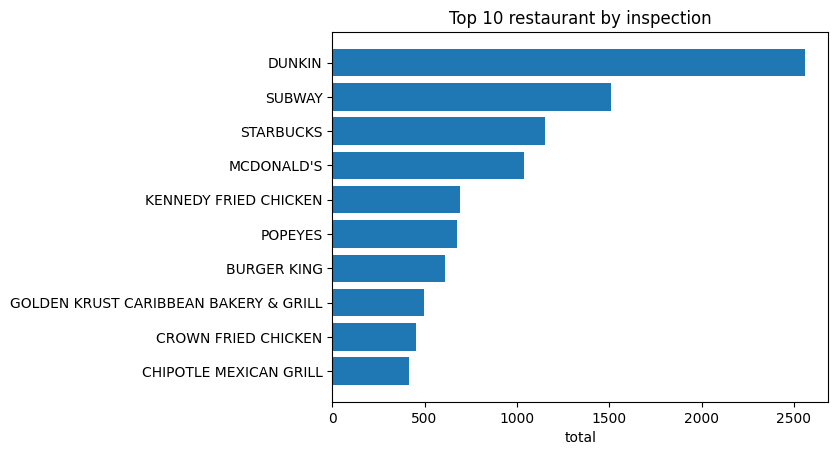

In [174]:
query = """
  SELECT
    dba AS restaurant,
    COUNT(dba) AS total
  FROM inspection
  WHERE dba IS NOT NULL
  GROUP BY dba
  ORDER BY total DESC
  LIMIT 10
"""
top_10_inspected = ctx.execute(query).sort("total")

plt.barh(top_10_inspected['restaurant'],
         top_10_inspected['total'])
plt.title("Top 10 restaurant by inspection")
plt.xlabel("total")
plt.show()

### Number of restaurants by neighborhood

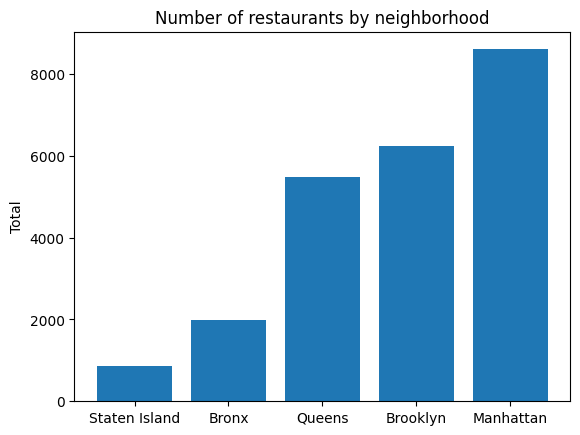

In [209]:
query = """
  SELECT
    COUNT(DISTINCT(dba)) AS total,
    boro AS neighborhood
  FROM inspection
  WHERE boro != '0'
  GROUP BY boro
  ORDER BY total ASC
"""

restaurant_by_neighborhood = ctx.execute(query)

plt.bar(
         restaurant_by_neighborhood["neighborhood"],
         restaurant_by_neighborhood["total"])
plt.title("Number of restaurants by neighborhood")
plt.ylabel('Total')
plt.show()

### Number of inspection by neighborhood

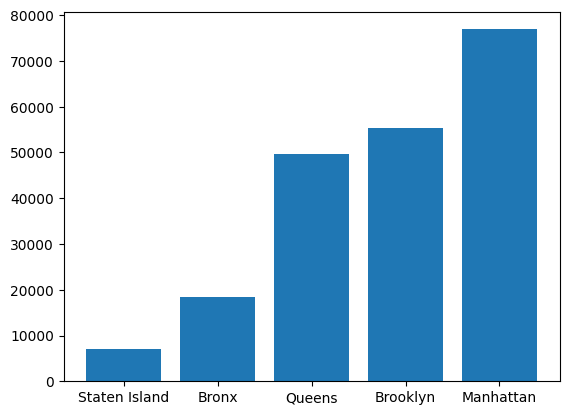

In [204]:
query = """
SELECT
  boro AS neighborhood,
  COUNT(*) AS total
FROM inspection
WHERE boro != '0'
GROUP BY boro
ORDER BY total
"""

inspection_by_neighborhood = ctx.execute(query)

plt.bar(inspection_by_neighborhood['neighborhood'],
        inspection_by_neighborhood['total'])

plt.show()

### Max, Min and Average score

In [407]:
query = """
SELECT
    MAX(score) AS max_score,
    MIN(score) AS min_score,
    AVG(score) AS avg_score
  FROM inspection
"""

ctx.execute(query).to_pandas()

,max_score,min_score,avg_score
0,168,0,22.732605


### Top 10 Best and Worst restaurant by score (Above the Average=23)

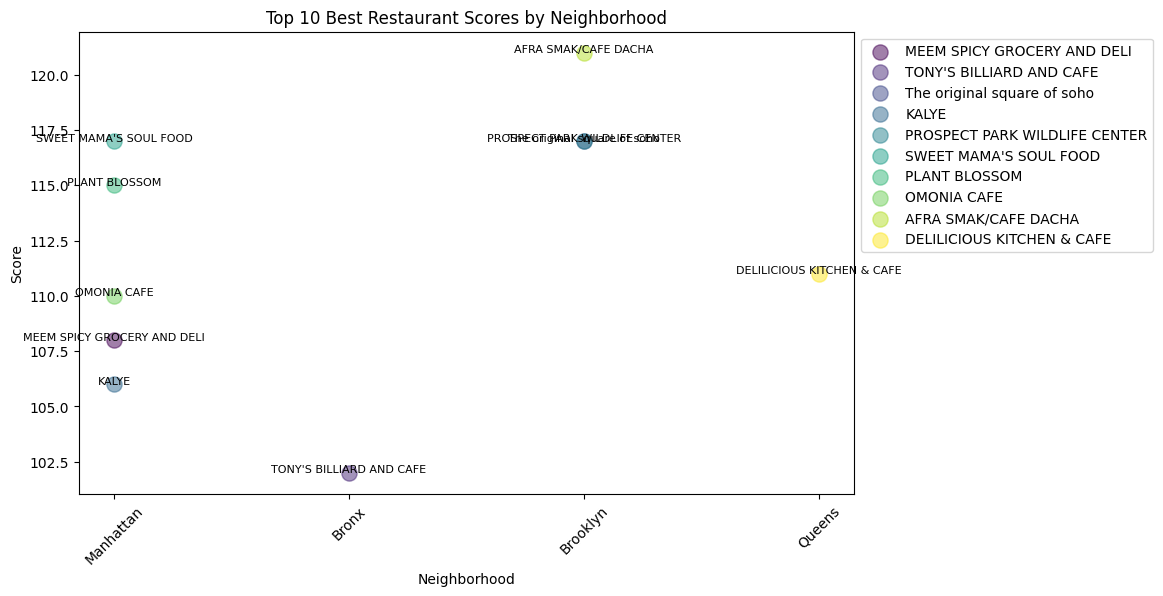

In [393]:
import numpy as np

query = f"""
  SELECT
    dba AS restaurant,
    boro AS neighborhood,
    ROUND(AVG(score)) AS avg_score,
    MAX(score) AS max_score,
    MIN(score) AS min_score
  FROM inspection
  WHERE (score IS NOT NULL) AND (boro != '0')
  GROUP BY dba, boro
  HAVING avg_score > {23}
"""

score_df = ctx.execute(query).lazy()

top_10_best_score = score_df.top_k(10,
                                   by="avg_score",
                                   descending=False).sort(by="avg_score").collect()


# Create a unique color for each restaurant
unique_restaurants = top_10_best_score['restaurant'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_restaurants)))

plt.figure(figsize=(10, 6))

# Scatter plot with unique colors for each restaurant
for i, restaurant in enumerate(unique_restaurants):
    subset = top_10_best_score.filter(pl.col('restaurant') == restaurant)
    plt.scatter(subset['neighborhood'], subset['avg_score'],
                s=120, c=[colors[i]], label=restaurant, alpha=0.5)

plt.xlabel('Neighborhood')
plt.ylabel('Score')
plt.title('Top 10 Best Restaurant Scores by Neighborhood')
plt.xticks(rotation=45)

# Annotate restaurant names near the data points
for row in top_10_best_score.iter_rows(named=True):
    plt.annotate(row['restaurant'], (row['neighborhood'],
                                     row['avg_score']),
                  fontsize=8,
                  ha='center', va='baseline')

# Add a legend to identify restaurants
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [405]:
rank_score = pl.from_arrow(duckdb.query("""
  SELECT
     dba AS restaurant,
     boro AS neighborhood,
     DENSE_RANK() OVER (ORDER BY AVG(score)) AS rank
  FROM df
  WHERE (score IS NOT NULL) AND (boro != '0')
  GROUP BY dba, boro
  ORDER BY rank DESC
""").arrow())

rank_score.lazy().sort(by="rank", descending=True).limit(10).collect().to_pandas()


,restaurant,neighborhood,rank
0,AFRA SMAK/CAFE DACHA,Brooklyn,4062
1,SWEET MAMA'S SOUL FOOD,Manhattan,4061
2,PROSPECT PARK WILDLIFE CENTER,Brooklyn,4060
3,The original square of soho,Brooklyn,4060
4,PLANT BLOSSOM,Manhattan,4059
5,DELILICIOUS KITCHEN & CAFE,Queens,4058
6,OMONIA CAFE,Manhattan,4057
7,MEEM SPICY GROCERY AND DELI,Manhattan,4056
8,KALYE,Manhattan,4055
9,TONY'S BILLIARD AND CAFE,Bronx,4054


Score by inspection_type

In [403]:
query = """
  SELECT
    AVG(score),
    inspection_type
  FROM inspection
  GROUP BY inspection_type
"""

ctx.execute(query).to_pandas()

,score,inspection_type
0,NaN,None
1,NaN,Trans Fat / Initial Inspection
2,NaN,Administrative Miscellaneous / Reopening Inspe...
3,22.140344,Cycle Inspection / Initial Inspection
4,NaN,Smoke-Free Air Act / Compliance Inspection
5,NaN,Administrative Miscellaneous / Compliance Insp...
6,NaN,Administrative Miscellaneous / Initial Inspection
7,20.852308,Inter-Agency Task Force / Initial Inspection
8,17.234375,Pre-permit (Non-operational) / Re-inspection
9,27.370370,Cycle Inspection / Second Compliance Inspection


TODO: Split the type column at '/'